In [33]:
import pandas as pd
from sklearn.model_selection import learning_curve,train_test_split,cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import mlflow as ml
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [34]:
df = pd.read_csv('data.csv')

In [35]:
# df2 = df.loc[0:9999]
# df2

In [36]:
df.NewExist = df.NewExist.astype(str)
df.UrbanRural= df.UrbanRural.astype(str)
df.Real_estate = df.Real_estate.astype(str)
df.FranchiseCode = df.FranchiseCode.apply(lambda x: 1 if x ==1 else 0)
df.FranchiseCode = df.FranchiseCode.astype(str)
df.CreateJob


0         0
1         0
2         0
3         0
4         7
         ..
894956    0
894957    0
894958    0
894959    0
894960    0
Name: CreateJob, Length: 894961, dtype: int64

In [37]:
X = df[['UrbanRural','CreateJob','RetainedJob','NoEmp','Real_estate','GrAppv','Industry','Term','FranchiseCode','NewExist']]
y = df['MIS_Status']
X_1, X_2, y_1, y_2 = train_test_split(X, y,shuffle=True, train_size=0.015, random_state=42, stratify=y)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1,shuffle=True, train_size=0.8, random_state=42, stratify=y_1)

In [11]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    remainder='passthrough'
    
    )

In [12]:
xgb= make_pipeline(
        transformer,
        XGBClassifier(
            max_depth=10,
            learning_rate=0.1,
            n_estimators=100,
            gamma=50, 
            min_child_weight=0,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.005
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
xgb.fit(X_train,y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9de71174c0>)])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsamp...
                               feature_types=None, gamma=50, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=0, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [13]:
xgb.named_steps['xgbclassifier']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=50, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

[ 859 2792 4725 6658 8591]


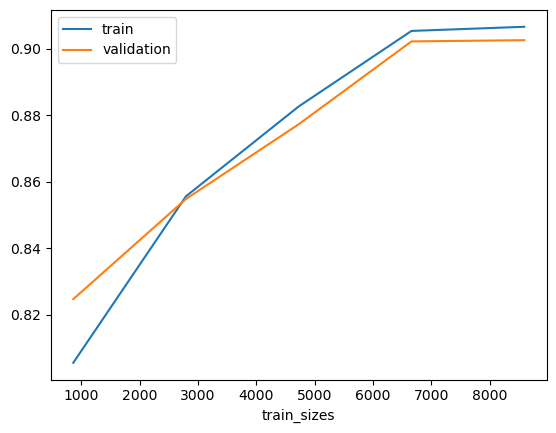

In [14]:
N, train_score, val_score = learning_curve(xgb, X_train, y_train,cv=5)
print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, pd.DataFrame(val_score).mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

In [15]:
transfo = make_pipeline(transformer, (StandardScaler())
)

In [16]:
X_train_standard =transfo.fit_transform(X_train)
X_train_standard

array([[ 0.43896712, -0.43896712,  0.43896712, ..., -0.12171183,
        -0.58168319, -0.32764728],
       [ 0.43896712, -0.43896712,  0.43896712, ..., -0.09990945,
         0.5450369 , -0.52007354],
       [ 0.43896712, -0.43896712,  0.43896712, ...,  0.05270718,
        -0.58168319, -0.32764728],
       ...,
       [ 0.43896712, -0.43896712,  0.43896712, ...,  0.02000361,
        -0.42567579, -0.48158829],
       [ 0.43896712, -0.43896712,  0.43896712, ..., -0.11081064,
        -0.52968072, -0.63552931],
       [ 0.43896712, -0.43896712,  0.43896712, ..., -0.09990945,
        -0.54701488, -0.94341133]])

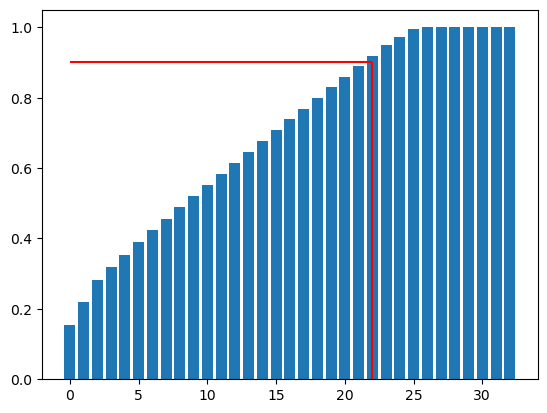

In [17]:
n_dims = X_train_standard.shape[1]
model = PCA(n_components=n_dims)
model.fit(X_train_standard)

variances = model.explained_variance_ratio_

meilleur_dims = np.argmax(np.cumsum(variances) > 0.90)

import matplotlib.pyplot as plt
plt.bar(range(n_dims), np.cumsum(variances))
plt.hlines(0.90, 0, meilleur_dims, colors='r')
plt.vlines(meilleur_dims, 0, 0.90, colors='r')

In [18]:
meilleur_dims

22

In [19]:
XGB2 = make_pipeline(
transfo,
PCA(n_components=meilleur_dims),
XGBClassifier(
            max_depth=10,
            learning_rate=0.1,
            n_estimators=100,
            gamma=50, 
            min_child_weight=0,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.005)
)

In [20]:
XGB2.fit(X_train,y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(sparse=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f9de71174c0>)])),
                                 ('standardscaler', StandardScaler())])),
                ('pca', PCA(n_components=22)),
                ('xgbclassifier',
                 XGBClassifier(...
                               feature_types=None, gamma=50, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=0, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [21]:
y_pred = cross_val_predict(XGB2,X_train,y_train)

In [ ]:
y_pred = XGB2.predict(X_train)

In [ ]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      8858
           1       0.71      0.10      0.17      1881

    accuracy                           0.83     10739
   macro avg       0.77      0.54      0.54     10739
weighted avg       0.82      0.83      0.78     10739



In [7]:
num_pipe = make_pipeline(StandardScaler(),PCA(n_components=4))

In [8]:
transformer2 = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    (num_pipe,make_column_selector(dtype_include=np.number)),
    

)

In [42]:
params = {'max_depth':10,'learning_rate':0.1,'n_estimators':100,'gamma':50,'min_child_weight':0,'subsample':0.8,'colsample_bytree':0.8,'reg_alpha':0.005}

In [43]:
xgb = make_pipeline(transformer2,
XGBClassifier().set_params(**params)
)

In [45]:
xgb.named_steps['xgbclassifier'].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 50,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': 0,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': 0.005,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [11]:
xgb.fit(X_train,y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f320bbdc730>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=4))]),
                                                  <sklearn.compose._column_transformer.make_column_selector obj...
                               feature_types=None, gamma=50, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=0, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [12]:
y_pred2 = cross_val_predict(xgb,X_train,y_train)
print(classification_report(y_train,y_pred2))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      8858
           1       0.63      0.42      0.51      1881

    accuracy                           0.86     10739
   macro avg       0.76      0.69      0.71     10739
weighted avg       0.84      0.86      0.84     10739



In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True, train_size=0.8, random_state=42, stratify=y)

In [16]:
xgb.fit(X_train,y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f320bbdc730>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=4))]),
                                                  <sklearn.compose._column_transformer.make_column_selector obj...
                               feature_types=None, gamma=50, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=0, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [17]:
y_pred2 = cross_val_predict(xgb,X_train,y_train)
print(classification_report(y_train,y_pred2))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93    590599
           1       0.70      0.50      0.59    125369

    accuracy                           0.88    715968
   macro avg       0.80      0.73      0.76    715968
weighted avg       0.87      0.88      0.87    715968



# Mflow

In [25]:
import mlflow



In [27]:
import os
import warnings
import sys
import mlflow.sklearn
import logging
from urllib.parse import urlparse
from sklearn.metrics import f1_score,precision_score,recall_score
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)




In [50]:
def eval_metrics(actual, pred):
    f1_macro =f1_score(actual, pred,average='macro')
    precision = precision_score(actual, pred)
    recall = recall_score(actual, pred)
    return f1_macro,precision,recall

In [40]:
experiment_id = mlflow.create_experiment("loan_analysis2")

Traceback (most recent call last):
  File "/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 285, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 378, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1082, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1075, in _read_helper
    result = read_yaml(root, file_name)
  File "/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 213, in read_yaml
    raise MissingConfigException("Yaml file '

In [53]:



with mlflow.start_run(experiment_id=experiment_id):
    xgb.fit(X_train,y_train)
    y_pred = xgb.predict(X_test)
    (f1_score_macro,precision,recall)=eval_metrics(y_test,y_pred)
    print("  f1_score_macro: %s" % f1_score_macro)
    print("  precision: %s" % precision)
    print("  recall: %s" % recall)
    for k,v in params.items():
        mlflow.log_param(k,v)
    mlflow.log_metric("f1_score_macro",f1_score_macro)
    mlflow.log_metric("precision",precision)
    mlflow.log_metric("recall",recall)
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    

  f1_score_macro: 0.6995955363949778
  precision: 0.618421052631579
  recall: 0.4
